<a href="https://www.kaggle.com/code/umarzafar/mohs-hardness-prediction-hgbr-ada-rf-cat?scriptVersionId=151970652" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s3e25/sample_submission.csv
/kaggle/input/playground-series-s3e25/train.csv
/kaggle/input/playground-series-s3e25/test.csv


# Necessary Libraries

In [2]:
from sklearn.metrics import median_absolute_error

import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import lightgbm as lgb

from sklearn.ensemble import HistGradientBoostingRegressor

# Data Exploration


<center>
<img src="https://media.lrng.org/31/84/f8f366b3fa9150c167a926e2d3730047a9a3-800x400.png" width=600>
</center>
<div style="padding:20px; 
            color:#ffffff;
            margin:10px;
            font-size:220%;
            text-align:center;
            display:fill;
            border-radius:20px;
            border-width: 5px;
            border-style: solid;
            border-color:#ffffff;
            background-color:#0000ff;
            overflow:hidden;
            font-weight:500">Let's Dive into Data</div>

In [3]:
train_data = pd.read_csv('/kaggle/input/playground-series-s3e25/train.csv')
test_data = pd.read_csv('/kaggle/input/playground-series-s3e25/test.csv')

submission_sample = pd.read_csv('/kaggle/input/playground-series-s3e25/sample_submission.csv')

In [4]:
train_data.head()

,id,allelectrons_Total,density_Total,allelectrons_Average,val_e_Average,atomicweight_Average,ionenergy_Average,el_neg_chi_Average,R_vdw_element_Average,R_cov_element_Average,zaratio_Average,density_Average,Hardness
0,0,100.0,0.841611,10.0,4.8,20.612526,11.08810,2.766,1.732,0.860,0.496070,0.91457,6.0
1,1,100.0,7.558488,10.0,4.8,20.298893,12.04083,2.755,1.631,0.910,0.492719,0.71760,6.5
2,2,76.0,8.885992,15.6,5.6,33.739258,12.08630,2.828,1.788,0.864,0.481478,1.50633,2.5
3,3,100.0,8.795296,10.0,4.8,20.213349,10.94850,2.648,1.626,0.936,0.489272,0.78937,6.0
4,4,116.0,9.577996,11.6,4.8,24.988133,11.82448,2.766,1.682,0.896,0.492736,1.86481,6.0


In [5]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10407 entries, 0 to 10406
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     10407 non-null  int64  
 1   allelectrons_Total     10407 non-null  float64
 2   density_Total          10407 non-null  float64
 3   allelectrons_Average   10407 non-null  float64
 4   val_e_Average          10407 non-null  float64
 5   atomicweight_Average   10407 non-null  float64
 6   ionenergy_Average      10407 non-null  float64
 7   el_neg_chi_Average     10407 non-null  float64
 8   R_vdw_element_Average  10407 non-null  float64
 9   R_cov_element_Average  10407 non-null  float64
 10  zaratio_Average        10407 non-null  float64
 11  density_Average        10407 non-null  float64
 12  Hardness               10407 non-null  float64
dtypes: float64(12), int64(1)
memory usage: 1.0 MB


In [6]:
train_data.describe()

,id,allelectrons_Total,density_Total,allelectrons_Average,val_e_Average,atomicweight_Average,ionenergy_Average,el_neg_chi_Average,R_vdw_element_Average,R_cov_element_Average,zaratio_Average,density_Average,Hardness
count,10407.00000,10407.000000,10407.000000,10407.000000,10407.000000,10407.000000,10407.000000,10407.000000,10407.000000,10407.000000,10407.000000,10407.000000,10407.000000
mean,5203.00000,128.053516,14.491342,17.033222,4.546789,37.507703,10.938308,2.607662,1.731330,0.944132,0.493349,2.132984,4.647126
std,3004.38646,224.123776,15.972877,10.468734,0.690864,26.012313,1.408276,0.334906,0.192481,0.180017,0.063080,1.936656,1.680525
min,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2601.50000,68.000000,7.558488,10.000000,4.000000,20.298893,10.590660,2.530000,1.672500,0.864000,0.476196,0.814800,3.000000
50%,5203.00000,100.000000,10.650000,12.600000,4.714286,26.203827,11.202760,2.706000,1.732727,0.915556,0.488550,1.351550,5.500000
75%,7804.50000,131.000000,16.676996,22.000000,4.800000,48.719500,11.670725,2.805000,1.800000,0.981667,0.496070,2.741550,6.000000
max,10406.00000,15300.000000,643.093804,67.000000,6.000000,167.400000,15.245810,3.443000,2.250000,1.615840,0.825990,10.970000,10.000000


# Correlations using HeatMap

<center>
<img src="https://media.lrng.org/31/84/f8f366b3fa9150c167a926e2d3730047a9a3-800x400.png" width=600>
</center>
<div style="padding:20px; 
            color:#150d0a;
            margin:10px;
            font-size:220%;
            text-align:center;
            display:fill;
            border-radius:20px;
            border-width: 5px;
            border-style: solid;
            border-color: #150d0a;
            background-color:#eca912;
            overflow:hidden;
            font-weight:500">HeatMap Analysis</div>

<Axes: >

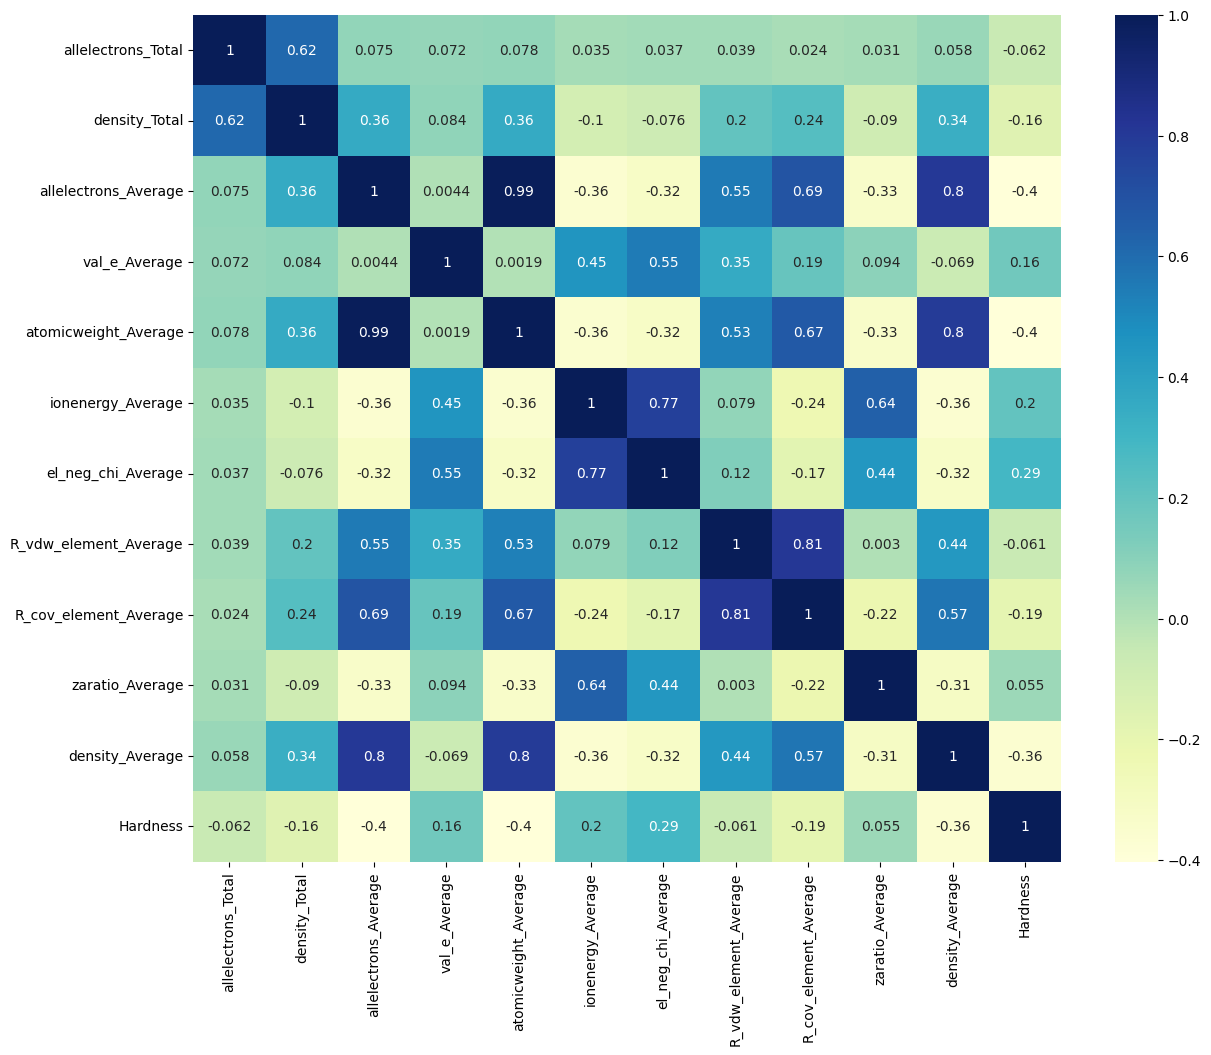

In [7]:
plt.figure(figsize = (14,11))
sns.heatmap(train_data[['allelectrons_Total', 'density_Total', 'allelectrons_Average',
       'val_e_Average', 'atomicweight_Average', 'ionenergy_Average',
       'el_neg_chi_Average', 'R_vdw_element_Average', 'R_cov_element_Average',
       'zaratio_Average', 'density_Average', 'Hardness']].corr(),
            cmap="YlGnBu",annot=True)

# FEATURE ENGINEERING


<center>
<img src="https://media.lrng.org/31/84/f8f366b3fa9150c167a926e2d3730047a9a3-800x400.png" width=600>
</center>
<div style="padding:20px; 
            color:#eca912;
            margin:10px;
            font-size:220%;
            text-align:center;
            display:fill;
            border-radius:20px;
            border-width: 5px;
            border-style: solid;
            border-color: #eca912;
            background-color:#340023;
            overflow:hidden;
            font-weight:500">Q-Q plot for Finding Non-Linearity in Data
    </div>

In [8]:
X=train_data[['allelectrons_Total', 'density_Total', 'allelectrons_Average',
       'val_e_Average', 'atomicweight_Average', 'ionenergy_Average',
       'el_neg_chi_Average', 'R_vdw_element_Average', 'R_cov_element_Average',
       'zaratio_Average', 'density_Average']].values
y= train_data['Hardness'].values

In [9]:
#Linear Regression using Stats Model
import statsmodels.api as sm
import numpy as np

# Add a constant term to the independent variables
X = sm.add_constant(X)

# Fit a linear regression model
model = sm.OLS(y, X)
result = model.fit()

# Get residuals
residuals = result.resid

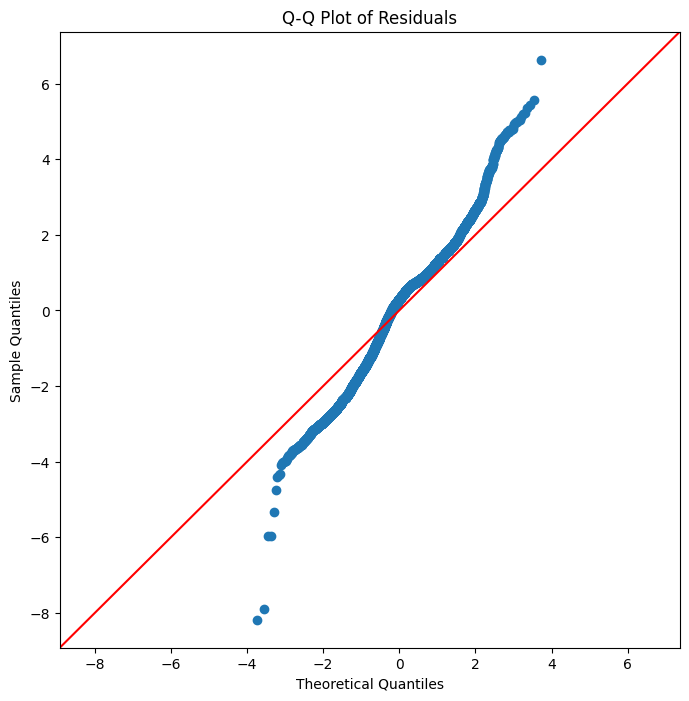

In [10]:
# Create a Q-Q plot
fig, ax = plt.subplots(figsize=(8, 8))
sm.qqplot(residuals, line='45', ax=ax)
ax.set_title('Q-Q Plot of Residuals')
plt.show()

                        The distribution is Non-linear and Bimodel

In [11]:
train_data.columns

Index(['id', 'allelectrons_Total', 'density_Total', 'allelectrons_Average',
       'val_e_Average', 'atomicweight_Average', 'ionenergy_Average',
       'el_neg_chi_Average', 'R_vdw_element_Average', 'R_cov_element_Average',
       'zaratio_Average', 'density_Average', 'Hardness'],
      dtype='object')

# Outliers Detection


<center>
<img src="https://media.lrng.org/31/84/f8f366b3fa9150c167a926e2d3730047a9a3-800x400.png" width=600>
</center>
<div style="padding:20px; 
            color:#ffffff;
            margin:10px;
            font-size:220%;
            text-align:center;
            display:fill;
            border-radius:20px;
            border-width: 5px;
            border-style: solid;
            border-color: #ffffff;
            background-color:#000000;
            overflow:hidden;
            font-weight:500">Finding Outliers in Features</div>

<Axes: >

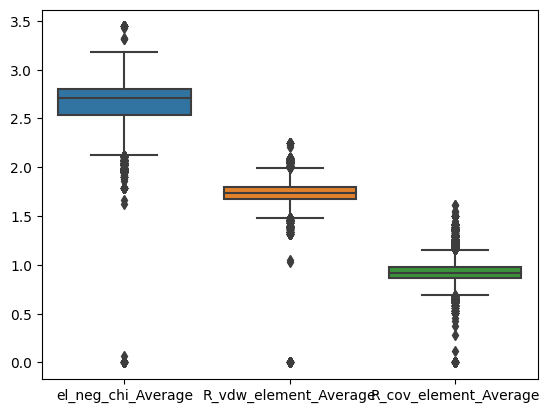

In [12]:
sns.boxplot(train_data[['el_neg_chi_Average', 'R_vdw_element_Average',
                  'R_cov_element_Average']])

<Axes: >

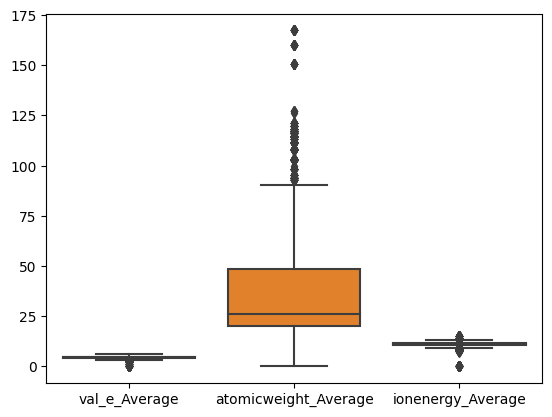

In [13]:
sns.boxplot(train_data[['val_e_Average', 'atomicweight_Average', 'ionenergy_Average']])

<Axes: >

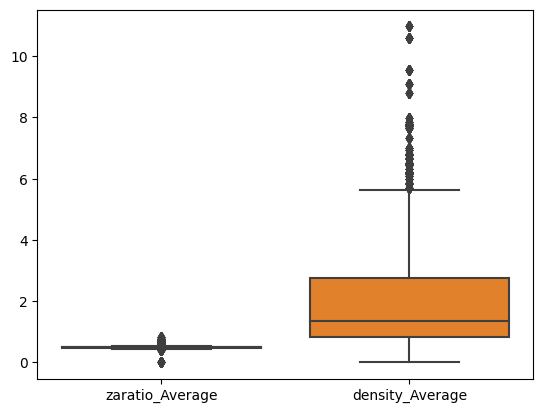

In [14]:
sns.boxplot(train_data[['zaratio_Average', 'density_Average']])

# Feature Selection and Generation


<center>
<img src="https://media.lrng.org/31/84/f8f366b3fa9150c167a926e2d3730047a9a3-800x400.png" width=600>
</center>
<div style="padding:20px; 
            color:#00005b;
            margin:10px;
            font-size:220%;
            text-align:center;
            display:fill;
            border-radius:20px;
            border-width: 5px;
            border-style: solid;
            border-color: #00005b;
            background-color:#00aeff;
            overflow:hidden;
            font-weight:500">Assessing Feature Importance using Random Forest </div>

In [15]:
X=train_data[['allelectrons_Total', 'density_Total', 'allelectrons_Average',
       'val_e_Average', 'atomicweight_Average', 'ionenergy_Average',
       'el_neg_chi_Average', 'R_vdw_element_Average', 'R_cov_element_Average',
       'zaratio_Average', 'density_Average']]
y= train_data['Hardness'].values


In [16]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
train_X, test_X, train_y, test_y = train_test_split(X,y,test_size=0.2 , random_state = 0)


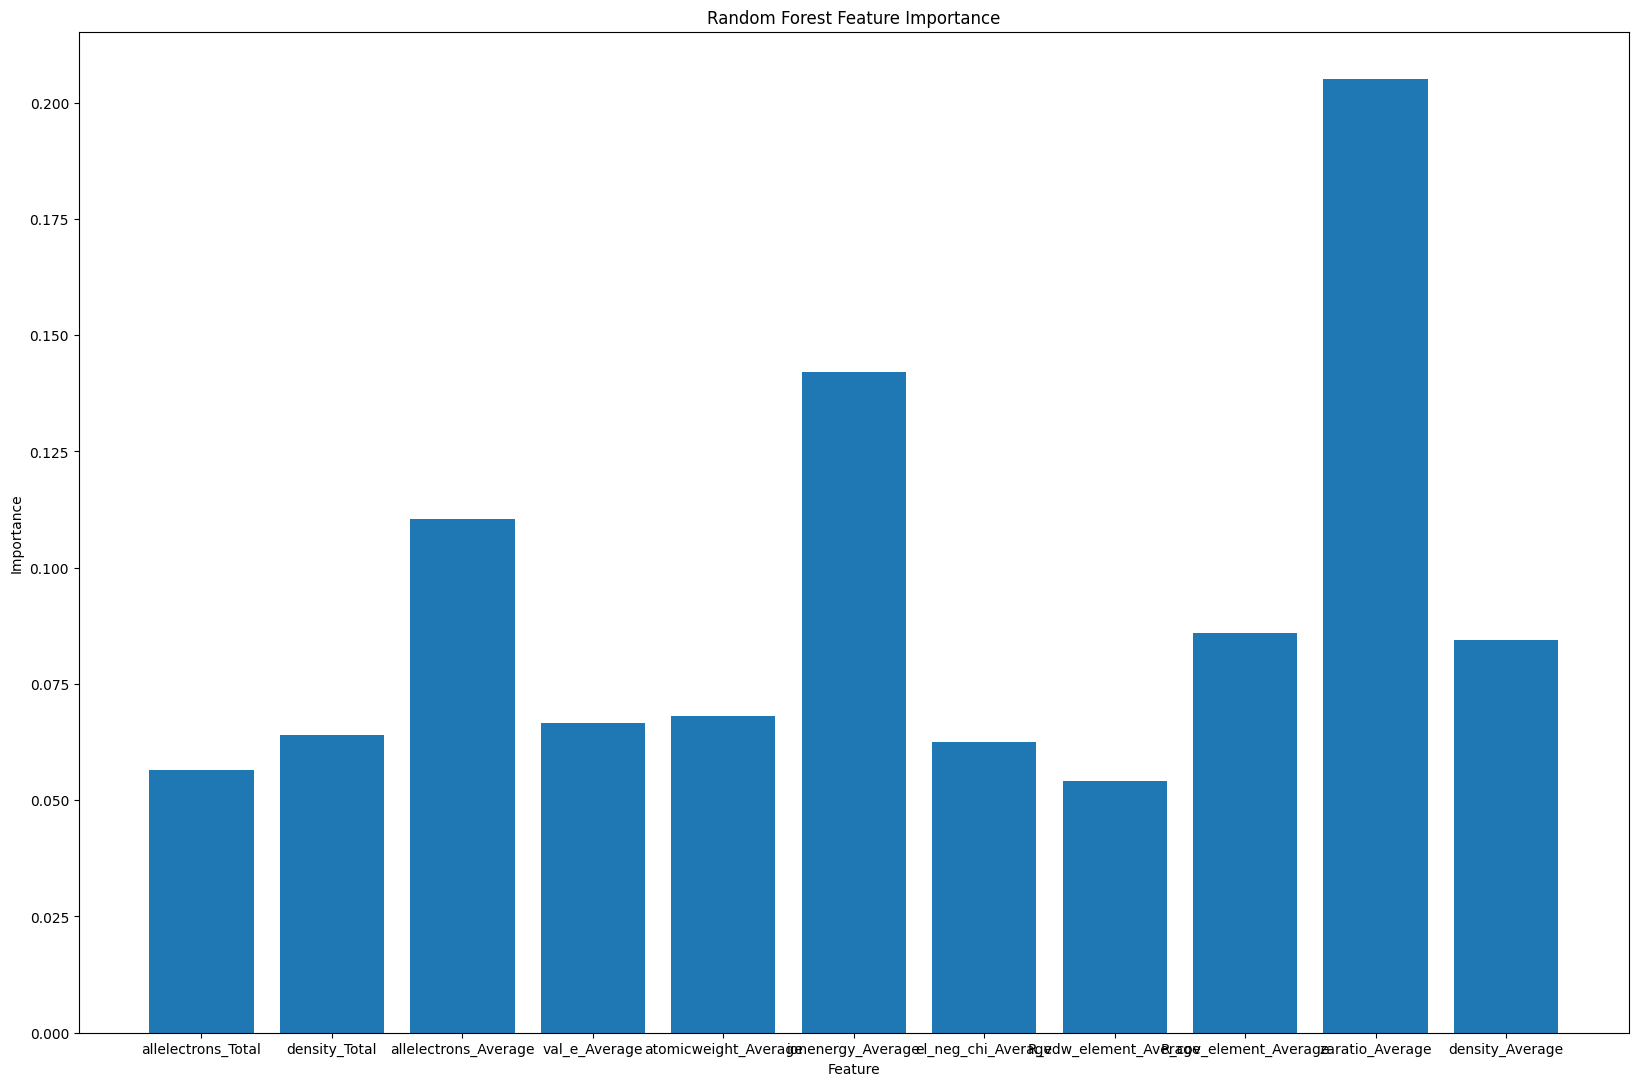

In [17]:
model = RandomForestRegressor()
model.fit(train_X, train_y)

# Get feature importances
feature_importances = model.feature_importances_

# Create a bar plot
plt.figure(figsize=(20,13))
plt.bar(range(len(feature_importances)),feature_importances, tick_label=train_X.columns)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Random Forest Feature Importance')
plt.show()

Most Important Features are : 'allelectrons_Average' ,'zaratio_Average',    'ionenergy_Average'

# Feature Crosses and Creating New Features

New Features:
* allelectrons_Average_squared
* ionenergy_Average_cubed

In [18]:
X['allelectrons_Average_squared'] = X['allelectrons_Average'] ** 2
X['ionenergy_Average_cubed'] = X['ionenergy_Average'] ** 3


/tmp/ipykernel_19/3902398150.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['allelectrons_Average_squared'] = X['allelectrons_Average'] ** 2


In [19]:
X.head()

,allelectrons_Total,density_Total,allelectrons_Average,val_e_Average,atomicweight_Average,ionenergy_Average,el_neg_chi_Average,R_vdw_element_Average,R_cov_element_Average,zaratio_Average,density_Average,allelectrons_Average_squared,ionenergy_Average_cubed
0,100.0,0.841611,10.0,4.8,20.612526,11.08810,2.766,1.732,0.860,0.496070,0.91457,100.00,1363.237117
1,100.0,7.558488,10.0,4.8,20.298893,12.04083,2.755,1.631,0.910,0.492719,0.71760,100.00,1745.698643
2,76.0,8.885992,15.6,5.6,33.739258,12.08630,2.828,1.788,0.864,0.481478,1.50633,243.36,1765.550360
3,100.0,8.795296,10.0,4.8,20.213349,10.94850,2.648,1.626,0.936,0.489272,0.78937,100.00,1312.392888
4,116.0,9.577996,11.6,4.8,24.988133,11.82448,2.766,1.682,0.896,0.492736,1.86481,134.56,1653.279014


# Splitting Data

In [20]:
train_X, test_X, train_y, test_y = train_test_split(X,y,test_size=0.2 , random_state = 0)

# Feature Scaling

<center>
<img src="https://media.lrng.org/31/84/f8f366b3fa9150c167a926e2d3730047a9a3-800x400.png" width=600>
</center>
<div style="padding:20px; 
            color:#ffffff;
            margin:10px;
            font-size:220%;
            text-align:center;
            display:fill;
            border-radius:20px;
            border-width: 5px;
            border-style: solid;
            border-color: #ffffff;
            background-color:#078539;
            overflow:hidden;
            font-weight:500">Transform Features</div>

In [21]:
#Scaling Features
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
train_X = sc.fit_transform(train_X)
test_X = sc.transform(test_X)

#  Simple starter Random Forest Model

In [22]:
seed = np.random.seed(6)

In [23]:
seed = np.random.seed(6)
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(train_X, train_y)

RandomForestRegressor(random_state=42)

In [24]:
rf_pred = rf.predict(test_X)
med_ae = median_absolute_error(test_y, rf_pred)
med_ae

0.6424999999999996

# Assessing Different Non-Linear Regression Models

<center>
<img src="https://media.lrng.org/31/84/f8f366b3fa9150c167a926e2d3730047a9a3-800x400.png" width=600>
</center>
<div style="padding:20px; 
            color:#000000;
            margin:10px;
            font-size:220%;
            text-align:center;
            display:fill;
            border-radius:20px;
            border-width: 5px;
            border-style: solid;
            border-color:#000000;
            background-color:#ffffff;
            overflow:hidden;
            font-weight:500">HistBoost |RandomForest |CatBoost |AdaBoost</div>

In [25]:
#Applying and Checking Median Absolute Error of different Regression Models
models = {'HistGB_Regressor':
          HistGradientBoostingRegressor(random_state = 42, loss = 'absolute_error'),
          'Random_Forest':RandomForestRegressor(n_estimators=100, random_state=42),
         'LightGB_Regressor':lgb.LGBMRegressor(n_estimators=100, random_state=seed),
          'CatBoost_Regressor':CatBoostRegressor(random_state=seed,verbose=0), 
          'AdaBoost_Regressor':AdaBoostRegressor(estimator=rf, n_estimators=50,learning_rate=1.0,random_state=seed)}

In [26]:
Mae = {}
for i in models: 
    obj = models[i]
    obj.fit(train_X, train_y)
    obj_pred = obj.predict(test_X)
    #accuracy = accuracy_score(test_y,obj_pred)
    med_ae = median_absolute_error(test_y, obj_pred)
    #precision = precision_score(test_y,obj_pred,zero_division=1)
    print('Median Abs. Error of '+i+': ',med_ae)
    key= i
    value= med_ae
    Mae[key]=value
    #print('Precision of '+i+': ',precision)

Median Abs. Error of HistGB_Regressor:  0.5306259985198998
Median Abs. Error of Random_Forest:  0.6424999999999996
Median Abs. Error of LightGB_Regressor:  0.6455714080642709
Median Abs. Error of CatBoost_Regressor:  0.660546546532836
Median Abs. Error of AdaBoost_Regressor:  0.7474999999999983


# Visualizing Results of Regression Models

<center>
<img src="https://media.lrng.org/31/84/f8f366b3fa9150c167a926e2d3730047a9a3-800x400.png" width=600>
</center>
<div style="padding:20px; 
            color:#eca912;
            margin:10px;
            font-size:220%;
            text-align:center;
            display:fill;
            border-radius:20px;
            border-width: 5px;
            border-style: solid;
            border-color: #eca912;
            background-color:#ff0000;
            overflow:hidden;
            font-weight:500">Unleashing Models' Accuracies</div>

Text(0.5, 1.0, 'Bar Plot of Regression Models Median_AE')

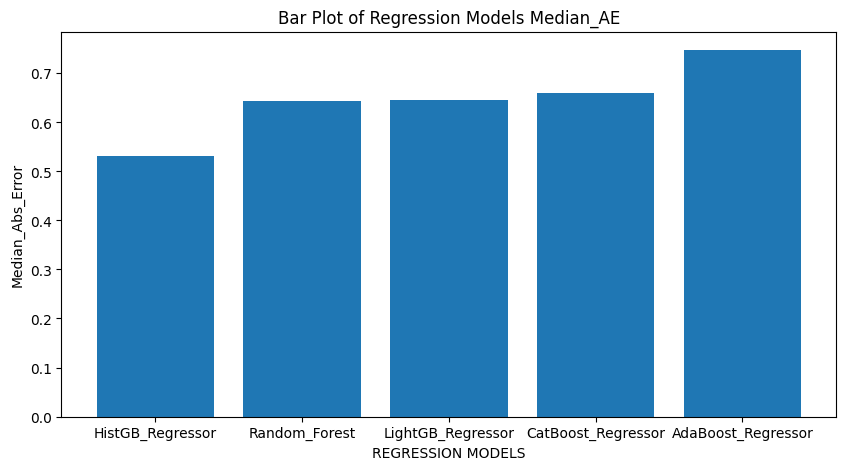

In [27]:
categories = list(Mae.keys())
values = list(Mae.values())

plt.figure(figsize=(10,5))
plt.bar(categories, values)
plt.xlabel('REGRESSION MODELS')
plt.ylabel('Median_Abs_Error')
plt.title('Bar Plot of Regression Models Median_AE')

# Show the plot
#plt.show()

                HistGB Regressor gives the lowest value od Median_abs_error
                

In [28]:
#Implementing HistGradientBoosting
from sklearn.ensemble import HistGradientBoostingRegressor
hgbr = HistGradientBoostingRegressor(random_state = 42, loss = 'absolute_error')
hgbr.fit(train_X, train_y)
hgbr_pred = hgbr.predict(test_X)
med_ae = median_absolute_error(test_y, hgbr_pred)
med_ae

0.5306259985198998

# K4-Cross Validation of HistGB_Regressor

<center>
<img src="https://media.lrng.org/31/84/f8f366b3fa9150c167a926e2d3730047a9a3-800x400.png" width=600>
</center>
<div style="padding:20px; 
            color:#004400;
            margin:10px;
            font-size:220%;
            text-align:center;
            display:fill;
            border-radius:20px;
            border-width: 5px;
            border-style: solid;
            border-color:#004400;
            background-color:#00ff00;
            overflow:hidden;
            font-weight:500">Cross-Validation</div>

In [29]:
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = hgbr, X=train_X, y=train_y, cv=8)

In [30]:
accuracies

array([0.46870015, 0.43353465, 0.40976685, 0.42972773, 0.49777469,
       0.44841476, 0.44709275, 0.40923708])

# Optimize Hyperparameters of HistGB_Regressor

<center>
<img src="https://media.lrng.org/31/84/f8f366b3fa9150c167a926e2d3730047a9a3-800x400.png" width=600>
</center>
<div style="padding:20px; 
            color:#ffffff;
            margin:10px;
            font-size:220%;
            text-align:center;
            display:fill;
            border-radius:20px;
            border-width: 5px;
            border-style: solid;
            border-color:#ffffff;
            background-color:#0000ff;
            overflow:hidden;
            font-weight:500">HyperParameters Tuning</div>

In [31]:
from sklearn.model_selection import GridSearchCV
grid = [{'max_iter': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]}]

grid_search = GridSearchCV(estimator = hgbr, cv=8,
                           param_grid = grid,
                          scoring = 'neg_median_absolute_error', n_jobs = -1)

grid_search = grid_search.fit(train_X, train_y)

In [32]:
grid_search.best_score_

-0.5274270942586309

In [33]:
grid_search.best_params_

{'learning_rate': 0.1, 'max_depth': 7, 'max_iter': 200}

In [34]:
hgr = HistGradientBoostingRegressor(random_state = 42,  loss = 'absolute_error',
                                   learning_rate=0.1, max_depth= 7, max_iter= 200)
hgr.fit(train_X, train_y)
hgr_pred = hgr.predict(test_X)
med_ae = median_absolute_error(test_y, hgr_pred)
med_ae

0.5357512528421235

# Submit Prediction

<center>
<img src="https://media.lrng.org/31/84/f8f366b3fa9150c167a926e2d3730047a9a3-800x400.png" width=600>
</center>
<div style="padding:20px; 
            color:#ffffff;
            margin:10px;
            font-size:220%;
            text-align:center;
            display:fill;
            border-radius:20px;
            border-width: 5px;
            border-style: solid;
            border-color: #ffffff;
            background-color:#000000;
            overflow:hidden;
            font-weight:500">Submission For Competition</div>

# Using Optimized Hist_GradientBoost Regressor

In [35]:
test_data = pd.read_csv('/kaggle/input/playground-series-s3e25/test.csv')
submission_sample = pd.read_csv('/kaggle/input/playground-series-s3e25/sample_submission.csv')
test_data_X=test_data[['allelectrons_Total', 'density_Total', 'allelectrons_Average',
       'val_e_Average', 'atomicweight_Average', 'ionenergy_Average',
       'el_neg_chi_Average', 'R_vdw_element_Average', 'R_cov_element_Average',
       'zaratio_Average', 'density_Average']]

In [36]:
test_data_X['allelectrons_Average_squared'] = test_data_X['allelectrons_Average'] ** 2
test_data_X['ionenergy_Average_cubed'] = test_data_X['ionenergy_Average'] ** 3
test_data_X = sc.transform(test_data_X)

In [37]:
test_prediction = hgbr.predict(test_data_X)

In [38]:
# Create Submission File
submission_df = pd.DataFrame({'id': submission_sample['id'], 'Hardness': test_prediction})
submission_df.to_csv('submission_file.csv', index=False)

In [39]:
submission_df.head()

,id,Hardness
0,10407,2.576429
1,10408,2.563744
2,10409,5.833803
3,10410,4.647693
4,10411,4.992014


# Kindly Upvote 👍